***
<font size="6"><center><b> HD-CapsNet: A Hierarchical Deep Capsule Network for Image Classification </b></center></font>
***

**Changing Model Architecture**
- **(Mod-3.1)** 32-D>16-D>8-D (Coarse>Medium>FINE) use skip connections between Secondary Capsules $Concatenate([P_{caps}, S_{coarse}])$ > input for $S_{medium}$ and $Concatenate([P_{caps}, S_{medium}])$ > input for $S_{fine}$
- With $L_{Cons}$

# Files and Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
from treelib import Tree
    # ML model, Dataset and evalution metrics
sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp # load datasets
from src import MixUp_add_loss # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models

    ## Tensorflow_docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

    # Auto reload local libraries if updated
%load_ext autoreload
%autoreload 2

# System information & GPU growth

In [2]:
systeminfo = sysenv.systeminfo()
print(systeminfo)


• Computer Name = posix
• Working Directory = /home/knoor/Downloads/RunningOnServer/HD_CapsNet/Training_and_Analysis/2_FMNIST
• Python Version = 3.9.16 (main, Mar  8 2023, 14:00:05) 
[GCC 11.2.0]
• TensorFlow Version = 2.8.4
• Keras Version = 2.8.0
• Current Environment = Not Using Anaconda


In [3]:
gpus = "0,1,2,3,4,5,6,7" ## Selecting Available gpus (Multi-GPUS)
gpus = "0" ## Selecting Available gpus (Single GPU)
gpugrowth = sysenv.gpugrowth(gpus = gpus) ## Limiting GPUS from OS environment
gpugrowth.memory_growth() #GPU memory growth

Following GPUS are selected =  0
Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


2023-05-11 13:00:40.803806: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-11 13:00:46.090463: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3904 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:5e:00.0, compute capability: 7.0


# Parameters

In [4]:
train_params = {"n_epochs" : 100,
                "batch_size": 64,
                "lr": 0.001, # Initial learning rate
                "lr_decay": 0.95, # Learning rate decay
                "decay_exe": 9, #learning rate decay execution epoch after
               }
model_params = {"optimizer": tf.keras.optimizers.Adam(train_params['lr']),
                "loss_function": models.MarginLoss(),
               }

# log directory

In [5]:
directory = sysenv.log_dir('2_FMNIST/HD_CapsNet/Mod_2_1')

FOLDER CREATED =  ../../logs/2_FMNIST/HD_CapsNet/Mod_2_1


# Import Dataset : FMNIST

In [6]:
dataset = datasets.F_MNIST(version = 'ALL') # importing Fashion MNIST Dataset
# dataset = datasets.F_MNIST(version = 'reduce') # importing Fashion MNIST Dataset

Fashion-MNIST dataset: Training have 60,000 samples and testing have 10,000 samples


## Learning Rate Decay Scheduler

In [7]:
def scheduler(epoch):
    learning_rate_init = train_params["lr"]
    
    if epoch > train_params["decay_exe"]:
        learning_rate_init = train_params["lr"] * (train_params["lr_decay"] ** (epoch-9))
        
    tf.summary.scalar('learning rate', data=learning_rate_init, step=epoch)
        
    return learning_rate_init

# Model Architecture

## Loss Function

In [8]:
number_of_classes_c = len(np.unique(np.argmax(dataset['y_train_coarse'], axis=1)))
number_of_classes_m = len(np.unique(np.argmax(dataset['y_train_medium'], axis=1)))
number_of_classes_f = len(np.unique(np.argmax(dataset['y_train_fine'], axis=1)))

## For Dynamic LossWeights
initial_lw = models.initial_lw({"coarse": number_of_classes_c,
                                "medium": number_of_classes_m,
                                "fine": number_of_classes_f})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'medium_lw' : K.variable(value = initial_lw['medium'], dtype="float32", name="medium_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : 0.0
             }

In [9]:
coarse_to_medium_array = np.zeros(shape=[number_of_classes_c,number_of_classes_m], dtype=np.int32)
medium_to_fine_array = np.zeros(shape=[number_of_classes_m,number_of_classes_f], dtype=np.int32)

c_id = np.argmax(dataset['y_train_coarse'],1)

m_id = np.argmax(dataset['y_train_medium'],1)

f_id = np.argmax(dataset['y_train_fine'],1)

for x in range(len(dataset['y_test_medium'])):
    coarse_to_medium_array[c_id[x]][m_id[x]] = 1
    
for x in range(len(dataset['y_test_fine'])):
    medium_to_fine_array[m_id[x]][f_id[x]] = 1

Matrix_coarse_to_medium_OneHot = tf.constant(coarse_to_medium_array, dtype=tf.float32)
Matrix_medium_to_fine_OneHot = tf.constant(medium_to_fine_array, dtype=tf.float32)

In [10]:
def margin_loss(y_true, y_proba):
    
    present_error_raw = tf.square(tf.maximum(0., 0.9 - y_proba), name="present_error_raw")
    absent_error_raw = tf.square(tf.maximum(0., y_proba - 0.1), name="absent_error_raw")
    L = tf.add(y_true * present_error_raw, 0.5 * (1.0 - y_true) * absent_error_raw,name="L")
    total_marginloss = tf.reduce_sum(L, axis=1, name="margin_loss")

    return total_marginloss


def consistency_check(y_pred_ancestor,y_pred_current,lookup_matrix,num_class_current):
    pred_max_ancestor = tf.argmax(y_pred_ancestor,axis=1)
    pred_max_current = tf.argmax(y_pred_current,axis=1)
    
    consistant_check = tf.gather(lookup_matrix, indices=pred_max_ancestor)*tf.one_hot(pred_max_current,num_class_current)
    
    return tf.reduce_sum(consistant_check,1)

def get_consistency(y_true_ancestor, y_pred, lookup_matrix):
    '''
    Get consistency based on 2 levels
    Provide ture levels for the level above, predictions for the current level and a look up metrix
    '''
    y_prob = tf.math.divide(y_pred,tf.reshape(tf.reduce_sum(y_pred,-1),(-1,1),name='reshape'),name='Probability')
    
    index_for_predictions = tf.cast(tf.math.argmax(y_true_ancestor,axis=1),dtype= 'int32')
    consistent_fine = tf.gather(lookup_matrix, indices=index_for_predictions) * y_prob
    Consistency_sum_array = tf.reduce_sum(consistent_fine, axis =1)
    
    return tf.abs(1-Consistency_sum_array)

def CustomLoss(y_true_c, y_true_m, y_true_f, y_pred_c, y_pred_m, y_pred_f, LW_C, LW_M, LW_F,
               number_of_classes_m, number_of_classes_f, C_Weight=0.2):
    
    con_m = consistency_check(y_pred_c,y_pred_m,Matrix_coarse_to_medium_OneHot,num_class_current=number_of_classes_m)
    con_m_not = tf.abs(con_m-1)
    
    con_f = consistency_check(y_pred_m,y_pred_f,Matrix_medium_to_fine_OneHot,num_class_current=number_of_classes_f)
    con_f_not = tf.abs(con_f-1)
    
    con_sum_m = get_consistency(y_true_c,y_pred_m,Matrix_coarse_to_medium_OneHot)
    con_sum_f = get_consistency(y_true_m,y_pred_f,Matrix_medium_to_fine_OneHot)
    
    medium_lvl_cosistency = con_sum_m * con_m_not
    fine_lvl_cosistency = con_sum_f * con_f_not    
   
    ML_c = margin_loss(y_true_c, y_pred_c)*LW_C
    ML_m = LW_M*((1-C_Weight)*(margin_loss(y_true_m, y_pred_m))+C_Weight*(medium_lvl_cosistency))
    ML_f = LW_F*((1-C_Weight)*(margin_loss(y_true_f, y_pred_f))+C_Weight*(fine_lvl_cosistency))
    
    batch_loss = ML_c + ML_m+ ML_f

    return tf.reduce_mean(batch_loss)

## Architecture

In [11]:
def get_compiled_model():
    
    ## Calling the HD-CapsNet Model
    model = models.HD_CapsNet_without_skip(input_shape     = dataset['x_train'].shape[1:], 
                                            input_shape_yc  = dataset['y_train_coarse'].shape[1:],
                                            input_shape_ym  = dataset['y_train_medium'].shape[1:],
                                            input_shape_yf  = dataset['y_train_fine'].shape[1:], 
                                            no_coarse_class = number_of_classes_c, 
                                            no_medium_class = number_of_classes_m, 
                                            no_fine_class   = number_of_classes_f,
                                            PCap_n_dims     = 8, 
                                            SCap_f_dims     = 8, 
                                            SCap_m_dims     = 16, 
                                            SCap_c_dims     = 32
                                            )
    
    ## Saving Model Architecture
    keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)
    
    ## Add Loss for Model
    model.add_loss(CustomLoss(y_true_c            = model.inputs[1], 
                              y_true_m            = model.inputs[2], 
                              y_true_f            = model.inputs[3], 
                              y_pred_c            = model.output[0], 
                              y_pred_m            = model.output[1], 
                              y_pred_f            = model.output[2], 
                              LW_C                = lossweight['coarse_lw'], 
                              LW_M                = lossweight['medium_lw'], 
                              LW_F                = lossweight['fine_lw'],
                              number_of_classes_m = number_of_classes_m, 
                              number_of_classes_f = number_of_classes_f, 
                              C_Weight            =0.2
                              )
                  )
    
    ## Compile Model
    model.compile(optimizer='adam',                  
                  metrics={'prediction_fine': 'accuracy',
                           'prediction_medium': 'accuracy',
                           'prediction_coarse': 'accuracy'}
                 )
    return model

## Compile Model

In [12]:
model = get_compiled_model()

In [13]:
model.summary()

Model: "HD-CapsNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 28, 28, 64)   640         ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 28, 28, 64)  256         ['block1_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 block1_conv2 (Conv2D)          (None, 28, 28, 64)   36928       ['batch_normalization[0]

                                                                                                  
 tf.cast (TFOpLambda)           (None,)              0           ['tf.math.argmax_4[0][0]']       
                                                                                                  
 tf.reshape (TFOpLambda)        (None, 1)            0           ['tf.math.reduce_sum_2[0][0]']   
                                                                                                  
 tf.math.argmax (TFOpLambda)    (None,)              0           ['prediction_coarse[0][0]']      
                                                                                                  
 tf.math.argmax_1 (TFOpLambda)  (None,)              0           ['prediction_medium[0][0]']      
                                                                                                  
 tf.math.argmax_5 (TFOpLambda)  (None,)              0           ['input_ym[0][0]']               
          

 da)                                                                                              
                                                                                                  
 tf.math.reduce_sum (TFOpLambda  (None,)             0           ['tf.math.multiply[0][0]']       
 )                                                                                                
                                                                                                  
 tf.math.maximum_4 (TFOpLambda)  (None, 10)          0           ['tf.math.subtract_10[0][0]']    
                                                                                                  
 tf.math.subtract_12 (TFOpLambd  (None, 10)          0           ['input_yf[0][0]']               
 a)                                                                                               
                                                                                                  
 tf.math.m

                                                                                                  
 tf.math.multiply_4 (TFOpLambda  (None,)             0           ['tf.math.abs_2[0][0]',          
 )                                                                'tf.math.abs[0][0]']            
                                                                                                  
 tf.math.add_2 (TFOpLambda)     (None, 10)           0           ['tf.math.multiply_16[0][0]',    
                                                                  'tf.math.multiply_18[0][0]']    
                                                                                                  
 tf.math.abs_3 (TFOpLambda)     (None,)              0           ['tf.math.subtract_3[0][0]']     
                                                                                                  
 tf.math.abs_1 (TFOpLambda)     (None,)              0           ['tf.math.subtract_1[0][0]']     
          

## Data Augmentation

In [14]:
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1)

training_generator = MixUp_add_loss.MixupGenerator_3level(dataset['x_train'],
                                                 dataset['y_train_coarse'], 
                                                 dataset['y_train_medium'],
                                                 dataset['y_train_fine'],
                                                 batch_size=train_params["batch_size"],
                                                 alpha=0.2, 
                                                 datagen=datagen
                                                )()

## Callback

In [15]:
tb = keras.callbacks.TensorBoard(directory+'/tb_logs'+ datetime.now().strftime("%Y%m%d-%H%M%S"))
log = keras.callbacks.CSVLogger(directory+'/log.csv', append=True)

checkpoint = keras.callbacks.ModelCheckpoint(directory+'/epoch-best.h5',
                                             monitor='val_prediction_fine_accuracy',
                                             save_best_only=True, 
                                             save_weights_only=True, 
                                             verbose=1)

change_lw = models.LossWeightsModifier(lossweight = lossweight,
                                       initial_lw = initial_lw,
                                       directory = directory)

lr_decay = keras.callbacks.LearningRateScheduler(scheduler)

# Model Training

In [16]:
model_save_dir = str(directory+'/trained_model.h5')
try:
    model.load_weights(model_save_dir)
except:
    history = model.fit(training_generator,
                        steps_per_epoch = int(dataset['x_train'].shape[0] / train_params["batch_size"]),
                        epochs = train_params["n_epochs"],
                        validation_data = ([dataset['x_test'],
                                            dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']],
                                           [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]),
                        callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                        verbose=1
                       )
    
    model.save_weights(model_save_dir)

Epoch 1/100


2023-05-11 13:01:03.207345: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2023-05-11 13:01:09.752996: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-11 13:01:09.987883: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] RESOURCE_EXHAUSTED: /tmp/tempfile-luthin-c6379f0b-2617260-5fb623352d90b; No space left on device
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


936/937 [============================>.] - ETA: 0s - loss: 0.1460 - prediction_coarse_accuracy: 0.9739 - prediction_medium_accuracy: 0.8312 - prediction_fine_accuracy: 0.5056
  • Coarse Accuracy = 97.39% | Val_Accuracy = 99.69% | LossWeight = 0.07 
  • Medium Accuracy = 83.13% | Val_Accuracy = 92.59% | LossWeight = 0.32 
  • Fine   Accuracy = 50.57% | Val_Accuracy = 71.53% | LossWeight = 0.62 

Epoch 1: val_prediction_fine_accuracy improved from -inf to 0.71530, saving model to ../../logs/2_FMNIST/HD_CapsNet/Mod_2_1/epoch-best.h5
937/937 [==============================] - 90s 65ms/step - loss: 0.1460 - prediction_coarse_accuracy: 0.9739 - prediction_medium_accuracy: 0.8313 - prediction_fine_accuracy: 0.5057 - val_loss: 0.0507 - val_prediction_coarse_accuracy: 0.9969 - val_prediction_medium_accuracy: 0.9259 - val_prediction_fine_accuracy: 0.7153 - lr: 0.0010
Epoch 2/100
937/937 [==============================] - ETA: 0s - loss: 0.0662 - prediction_coarse_accuracy: 0.9824 - prediction_me

937/937 [==============================] - 56s 60ms/step - loss: 0.0464 - prediction_coarse_accuracy: 0.9853 - prediction_medium_accuracy: 0.9436 - prediction_fine_accuracy: 0.8973 - val_loss: 0.0173 - val_prediction_coarse_accuracy: 0.9983 - val_prediction_medium_accuracy: 0.9620 - val_prediction_fine_accuracy: 0.9223 - lr: 0.0010
Epoch 10/100
937/937 [==============================] - ETA: 0s - loss: 0.0459 - prediction_coarse_accuracy: 0.9852 - prediction_medium_accuracy: 0.9452 - prediction_fine_accuracy: 0.9010
  • Coarse Accuracy = 98.52% | Val_Accuracy = 99.85% | LossWeight = 0.14 
  • Medium Accuracy = 94.52% | Val_Accuracy = 96.82% | LossWeight = 0.39 
  • Fine   Accuracy = 90.10% | Val_Accuracy = 92.31% | LossWeight = 0.47 

Epoch 10: val_prediction_fine_accuracy improved from 0.92230 to 0.92310, saving model to ../../logs/2_FMNIST/HD_CapsNet/Mod_2_1/epoch-best.h5
937/937 [==============================] - 56s 60ms/step - loss: 0.0459 - prediction_coarse_accuracy: 0.9852 - pr

Epoch 19/100
937/937 [==============================] - ETA: 0s - loss: 0.0396 - prediction_coarse_accuracy: 0.9889 - prediction_medium_accuracy: 0.9609 - prediction_fine_accuracy: 0.9262
  • Coarse Accuracy = 98.89% | Val_Accuracy = 99.85% | LossWeight = 0.14 
  • Medium Accuracy = 96.09% | Val_Accuracy = 96.92% | LossWeight = 0.38 
  • Fine   Accuracy = 92.62% | Val_Accuracy = 93.39% | LossWeight = 0.48 

Epoch 19: val_prediction_fine_accuracy did not improve from 0.93460
937/937 [==============================] - 56s 60ms/step - loss: 0.0396 - prediction_coarse_accuracy: 0.9889 - prediction_medium_accuracy: 0.9609 - prediction_fine_accuracy: 0.9262 - val_loss: 0.0148 - val_prediction_coarse_accuracy: 0.9985 - val_prediction_medium_accuracy: 0.9692 - val_prediction_fine_accuracy: 0.9339 - lr: 6.3025e-04
Epoch 20/100
936/937 [============================>.] - ETA: 0s - loss: 0.0394 - prediction_coarse_accuracy: 0.9891 - prediction_medium_accuracy: 0.9614 - prediction_fine_accuracy: 0.

937/937 [==============================] - ETA: 0s - loss: 0.0372 - prediction_coarse_accuracy: 0.9907 - prediction_medium_accuracy: 0.9689 - prediction_fine_accuracy: 0.9407
  • Coarse Accuracy = 99.07% | Val_Accuracy = 99.85% | LossWeight = 0.15 
  • Medium Accuracy = 96.89% | Val_Accuracy = 97.38% | LossWeight = 0.37 
  • Fine   Accuracy = 94.07% | Val_Accuracy = 94.21% | LossWeight = 0.48 

Epoch 28: val_prediction_fine_accuracy improved from 0.94140 to 0.94210, saving model to ../../logs/2_FMNIST/HD_CapsNet/Mod_2_1/epoch-best.h5
937/937 [==============================] - 57s 61ms/step - loss: 0.0372 - prediction_coarse_accuracy: 0.9907 - prediction_medium_accuracy: 0.9689 - prediction_fine_accuracy: 0.9407 - val_loss: 0.0130 - val_prediction_coarse_accuracy: 0.9985 - val_prediction_medium_accuracy: 0.9738 - val_prediction_fine_accuracy: 0.9421 - lr: 3.9721e-04
Epoch 29/100
937/937 [==============================] - ETA: 0s - loss: 0.0366 - prediction_coarse_accuracy: 0.9907 - pred

937/937 [==============================] - ETA: 0s - loss: 0.0358 - prediction_coarse_accuracy: 0.9914 - prediction_medium_accuracy: 0.9731 - prediction_fine_accuracy: 0.9513
  • Coarse Accuracy = 99.14% | Val_Accuracy = 99.88% | LossWeight = 0.16 
  • Medium Accuracy = 97.31% | Val_Accuracy = 97.55% | LossWeight = 0.38 
  • Fine   Accuracy = 95.13% | Val_Accuracy = 94.38% | LossWeight = 0.46 

Epoch 37: val_prediction_fine_accuracy did not improve from 0.94390
937/937 [==============================] - 56s 60ms/step - loss: 0.0358 - prediction_coarse_accuracy: 0.9914 - prediction_medium_accuracy: 0.9731 - prediction_fine_accuracy: 0.9513 - val_loss: 0.0130 - val_prediction_coarse_accuracy: 0.9988 - val_prediction_medium_accuracy: 0.9755 - val_prediction_fine_accuracy: 0.9438 - lr: 2.5034e-04
Epoch 38/100
937/937 [==============================] - ETA: 0s - loss: 0.0355 - prediction_coarse_accuracy: 0.9909 - prediction_medium_accuracy: 0.9734 - prediction_fine_accuracy: 0.9518
  • Coar

937/937 [==============================] - 57s 61ms/step - loss: 0.0345 - prediction_coarse_accuracy: 0.9917 - prediction_medium_accuracy: 0.9767 - prediction_fine_accuracy: 0.9584 - val_loss: 0.0129 - val_prediction_coarse_accuracy: 0.9989 - val_prediction_medium_accuracy: 0.9756 - val_prediction_fine_accuracy: 0.9447 - lr: 1.5778e-04
Epoch 47/100
937/937 [==============================] - ETA: 0s - loss: 0.0350 - prediction_coarse_accuracy: 0.9917 - prediction_medium_accuracy: 0.9764 - prediction_fine_accuracy: 0.9570
  • Coarse Accuracy = 99.17% | Val_Accuracy = 99.90% | LossWeight = 0.17 
  • Medium Accuracy = 97.64% | Val_Accuracy = 97.47% | LossWeight = 0.37 
  • Fine   Accuracy = 95.70% | Val_Accuracy = 94.26% | LossWeight = 0.45 

Epoch 47: val_prediction_fine_accuracy did not improve from 0.94540
937/937 [==============================] - 57s 60ms/step - loss: 0.0350 - prediction_coarse_accuracy: 0.9917 - prediction_medium_accuracy: 0.9764 - prediction_fine_accuracy: 0.9570 - 

Epoch 56/100
936/937 [============================>.] - ETA: 0s - loss: 0.0345 - prediction_coarse_accuracy: 0.9920 - prediction_medium_accuracy: 0.9772 - prediction_fine_accuracy: 0.9595
  • Coarse Accuracy = 99.20% | Val_Accuracy = 99.88% | LossWeight = 0.18 
  • Medium Accuracy = 97.73% | Val_Accuracy = 97.71% | LossWeight = 0.38 
  • Fine   Accuracy = 95.95% | Val_Accuracy = 94.90% | LossWeight = 0.45 

Epoch 56: val_prediction_fine_accuracy improved from 0.94810 to 0.94900, saving model to ../../logs/2_FMNIST/HD_CapsNet/Mod_2_1/epoch-best.h5
937/937 [==============================] - 57s 61ms/step - loss: 0.0345 - prediction_coarse_accuracy: 0.9920 - prediction_medium_accuracy: 0.9773 - prediction_fine_accuracy: 0.9595 - val_loss: 0.0123 - val_prediction_coarse_accuracy: 0.9988 - val_prediction_medium_accuracy: 0.9771 - val_prediction_fine_accuracy: 0.9490 - lr: 9.4468e-05
Epoch 57/100
937/937 [==============================] - ETA: 0s - loss: 0.0342 - prediction_coarse_accuracy: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



937/937 [==============================] - ETA: 0s - loss: 0.0343 - prediction_coarse_accuracy: 0.9920 - prediction_medium_accuracy: 0.9786 - prediction_fine_accuracy: 0.9626
  • Coarse Accuracy = 99.20% | Val_Accuracy = 99.91% | LossWeight = 0.19 
  • Medium Accuracy = 97.86% | Val_Accuracy = 97.64% | LossWeight = 0.38 
  • Fine   Accuracy = 96.26% | Val_Accuracy = 94.63% | LossWeight = 0.44 

Epoch 74: val_prediction_fine_accuracy did not improve from 0.94900
937/937 [==============================] - 56s 60ms/step - loss: 0.0343 - prediction_coarse_accuracy: 0.9920 - prediction_medium_accuracy: 0.9786 - prediction_fine_accuracy: 0.9626 - val_loss: 0.0128 - val_prediction_coarse_accuracy: 0.9991 - val_prediction_medium_accuracy: 0.9764 - val_prediction_fine_accuracy: 0.9463 - lr: 3.7524e-05
Epoch 75/100
936/937 [============================>.] - ETA: 0s - loss: 0.0343 - prediction_coarse_accuracy: 0.9916 - prediction_medium_accuracy: 0.9784 - prediction_fine_accuracy: 0.9629
  • Coar

937/937 [==============================] - 57s 61ms/step - loss: 0.0342 - prediction_coarse_accuracy: 0.9923 - prediction_medium_accuracy: 0.9783 - prediction_fine_accuracy: 0.9640 - val_loss: 0.0126 - val_prediction_coarse_accuracy: 0.9991 - val_prediction_medium_accuracy: 0.9760 - val_prediction_fine_accuracy: 0.9470 - lr: 2.3650e-05
Epoch 84/100
937/937 [==============================] - ETA: 0s - loss: 0.0339 - prediction_coarse_accuracy: 0.9925 - prediction_medium_accuracy: 0.9797 - prediction_fine_accuracy: 0.9647
  • Coarse Accuracy = 99.25% | Val_Accuracy = 99.90% | LossWeight = 0.19 
  • Medium Accuracy = 97.97% | Val_Accuracy = 97.64% | LossWeight = 0.38 
  • Fine   Accuracy = 96.47% | Val_Accuracy = 94.73% | LossWeight = 0.44 

Epoch 84: val_prediction_fine_accuracy did not improve from 0.94900
937/937 [==============================] - 57s 60ms/step - loss: 0.0339 - prediction_coarse_accuracy: 0.9925 - prediction_medium_accuracy: 0.9797 - prediction_fine_accuracy: 0.9647 - 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



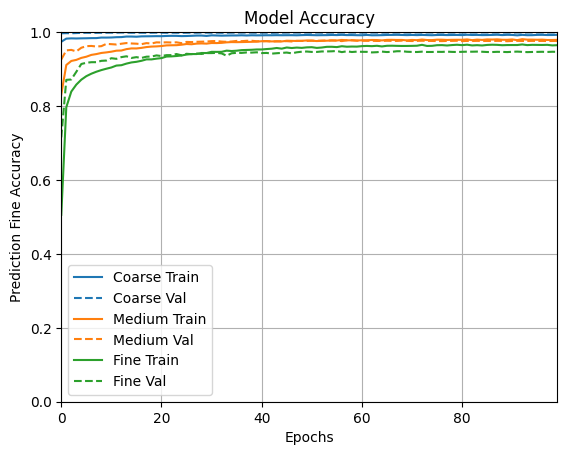

In [17]:
try:
    history_dict = history.history

    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
    plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
    plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
    plt.title("Model Accuracy")
    plt.ylim([0,1])
except:
    print('Trained model weights loaded')

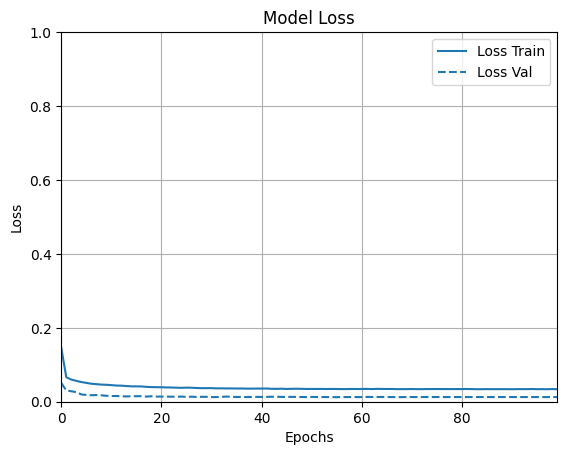

In [18]:
try:
    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"loss": history}, metric = "loss")
    plt.title("Model Loss")
    plt.ylim([0,1])
except:
    print('Trained model weights loaded')

## Model Analysis

In [19]:
final_model = keras.Model(model.inputs[:1], model.output)

lossfn = models.MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : lossfn,
                          'prediction_medium' : lossfn,
                          'prediction_coarse' : lossfn},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

313/313 [==============================] - 10s 20ms/step - loss: 0.0255 - prediction_coarse_loss: 0.0010 - prediction_medium_loss: 0.0180 - prediction_fine_loss: 0.0424 - prediction_coarse_accuracy: 0.9991 - prediction_medium_accuracy: 0.9763 - prediction_fine_accuracy: 0.9466
1. loss ==> 0.025545289739966393
2. prediction_coarse_loss ==> 0.0010145825799554586
3. prediction_medium_loss ==> 0.017985498532652855
4. prediction_fine_loss ==> 0.042399629950523376
5. prediction_coarse_accuracy ==> 0.9991000294685364
6. prediction_medium_accuracy ==> 0.9763000011444092
7. prediction_fine_accuracy ==> 0.9466000199317932
313/313 [==============================] - 3s 8ms/step


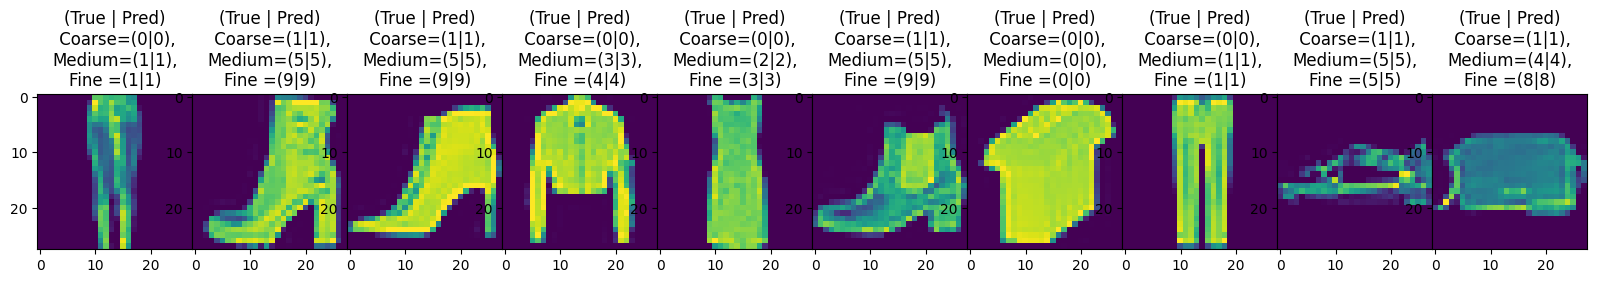

In [20]:
model_analysis = models.model_analysis(final_model, dataset)
results = model_analysis.evaluate()
predictions = model_analysis.prediction()

In [21]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1],predictions[2]]


  • Confusion_Matrix 

  • COARSE LEVEL 
[[5994    6]
 [   3 3997]]

  • MEDIUM LEVEL 
[[2908    2   28   55    7    0]
 [   2  991    6    0    0    1]
 [  46    2  940   12    0    0]
 [  61    0   10  929    0    0]
 [   3    0    1    0  996    0]
 [   0    0    0    0    1 2999]]

  • FINE LEVEL 
[[891   0  20   8   1   0  76   0   4   0]
 [  0 991   1   6   0   1   1   0   0   0]
 [ 12   1 926   5  23   0  33   0   0   0]
 [ 11   2  10 940  12   0  25   0   0   0]
 [  1   0  24  10 933   0  32   0   0   0]
 [  0   0   0   0   0 993   0   4   0   3]
 [ 64   1  38  15  34   0 845   0   3   0]
 [  0   0   0   0   0   3   0 984   0  13]
 [  0   1   0   1   0   0   1   0 997   0]
 [  0   0   0   0   0   7   0  26   1 966]]

  • Classification Report 


  • COARSE LEVEL 


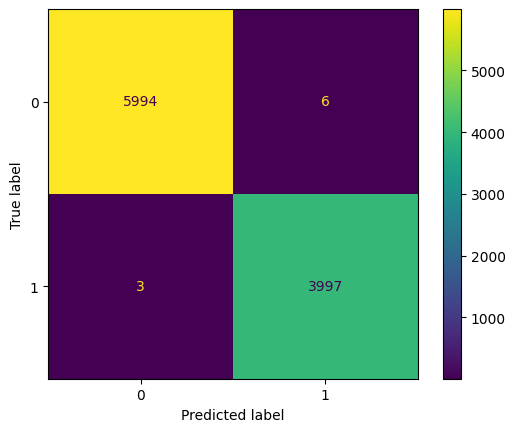

              precision    recall  f1-score   support

           0    0.99950   0.99900   0.99925      6000
           1    0.99850   0.99925   0.99888      4000

    accuracy                        0.99910     10000
   macro avg    0.99900   0.99913   0.99906     10000
weighted avg    0.99910   0.99910   0.99910     10000


  • MEDIUM LEVEL 


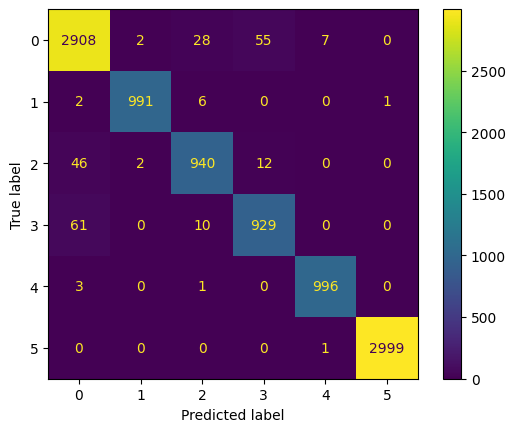

              precision    recall  f1-score   support

           0    0.96291   0.96933   0.96611      3000
           1    0.99598   0.99100   0.99348      1000
           2    0.95431   0.94000   0.94710      1000
           3    0.93273   0.92900   0.93086      1000
           4    0.99203   0.99600   0.99401      1000
           5    0.99967   0.99967   0.99967      3000

    accuracy                        0.97630     10000
   macro avg    0.97294   0.97083   0.97187     10000
weighted avg    0.97628   0.97630   0.97628     10000


  • FINE LEVEL 


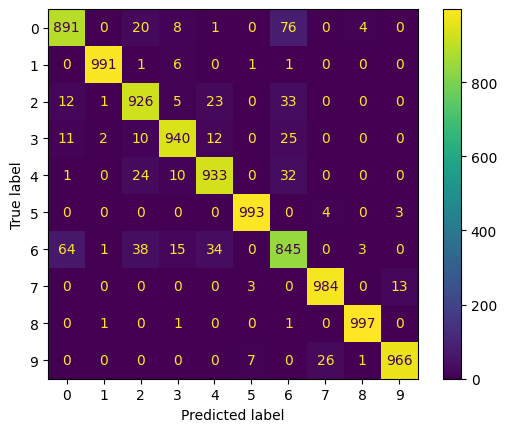

              precision    recall  f1-score   support

           0    0.91011   0.89100   0.90045      1000
           1    0.99498   0.99100   0.99299      1000
           2    0.90873   0.92600   0.91729      1000
           3    0.95431   0.94000   0.94710      1000
           4    0.93021   0.93300   0.93160      1000
           5    0.98904   0.99300   0.99102      1000
           6    0.83416   0.84500   0.83954      1000
           7    0.97041   0.98400   0.97716      1000
           8    0.99204   0.99700   0.99451      1000
           9    0.98371   0.96600   0.97477      1000

    accuracy                        0.94660     10000
   macro avg    0.94677   0.94660   0.94664     10000
weighted avg    0.94677   0.94660   0.94664     10000



In [22]:
## Level wise metrics analysis ##
metrics.lvl_wise_metric(true_label,pred_label)

In [23]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,
                                                               pred_label,
                                                               dataset['tree']
                                                               )
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.9739516666666667 
Hierarchical Recall = 0.9742 
Hierarchical F1-Score = 0.9740559523809523 
Consistency =  0.9987 
Exact Match =  0.946
